In [1]:
%matplotlib inline

In [2]:
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, Layout
from IPython.display import display
import pickle
from nipype.interfaces.nipy import SpaceTimeRealigner
from nipype.interfaces.fsl import BET, MeanImage, ApplyMask
import seaborn as sns
from nipype.interfaces.ants import N4BiasFieldCorrection, Registration

In [3]:
out_dir = '/home/julia/projects/lc/JH_lc_anatomy_02_analysis/'
method_file = '/home/julia/projects/lc/20180808_162705_JH_lc_anatomy_02_1_2/41/method'
par_file = '/home/julia/projects/lc/20180808_162705_JH_lc_anatomy_02_1_2_nifti/JHlcanatomy02/JHlcanatomy02_41/JHlcanatomy02_41_visu_pars.npy'
func_file = '/home/julia/projects/lc/20180808_162705_JH_lc_anatomy_02_1_2_nifti/JHlcanatomy02/JHlcanatomy02_41/JHlcanatomy02_41.nii.gz'
struct_file = '/home/julia/projects/lc/20180808_162705_JH_lc_anatomy_02_1_2_nifti/JHlcanatomy02/JHlcanatomy02_23/JHlcanatomy02_23.nii.gz'
atlas_file = '/home/julia/projects/allen_brain/P56_Atlas_different.nii'
func_data = nb.load(func_file).get_data()
func_affine = nb.load(func_file).affine
func_header = nb.load(func_file).header
struct_data = nb.load(struct_file).get_data()
struct_affine = nb.load(struct_file).affine
struct_header = nb.load(struct_file).header

### Read parameters

In [4]:
with open(method_file) as method:
    lines = method.readlines()
pars = np.load(par_file)[()]

In [5]:
TR = pars['VisuAcqRepetitionTime']
slice_order_str = lines[lines.index([s for s in lines if '##$PVM_ObjOrderList'.lower() in s.lower()][0])+1]
slice_order = [int(s) for s in slice_order_str.split(' ')]
single_slice = TR/ len(slice_order)
slice_times = [s*single_slice for s in slice_order]

### Remove initial volumes

In [15]:
vol_to_remove = 10
func_steady = nb.Nifti1Image(func_data[:,:,:,vol_to_remove:], func_affine, func_header)
nb.save(func_steady, out_dir+'func_steady.nii.gz')

### Remove thermal noise

In [ ]:
# Jelles denoising
# in:  out_dir+'func_steady.nii.gz'
# out:  out_dir+'func_clean.nii.gz'

### Slice time + motion correction

In [77]:
slicemoco = SpaceTimeRealigner(in_file=out_dir+'func_clean.nii.gz',
                               slice_times=[s/1000 for s in slice_times], 
                               tr=TR/1000, 
                               slice_info=2)
res = slicemoco.run()
func_slicemoco = nb.load(res.outputs.out_file)
nb.save(func_slicemoco, out_dir+'func_slicemoco.nii.gz')
par_file = np.loadtxt(res.outputs.par_file)
np.savetxt(out_dir + 'motion_par.txt', par_file)

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


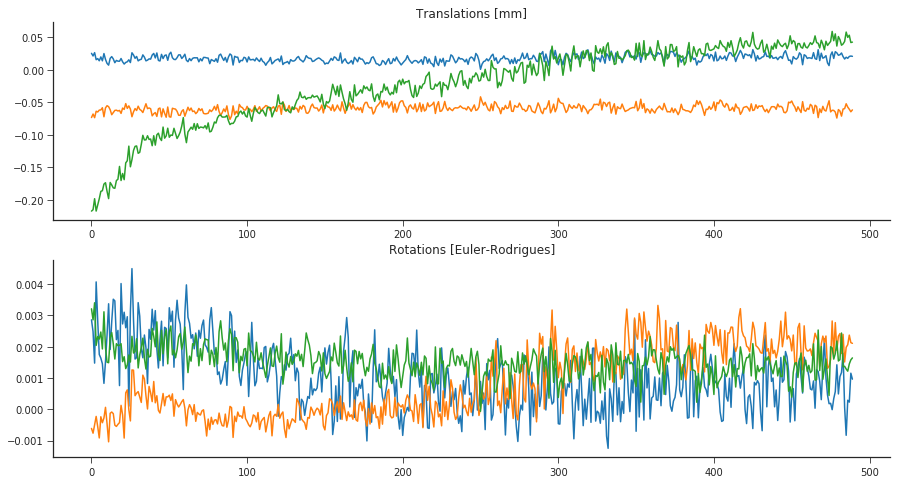

In [80]:
sns.set_style("ticks")
fig=plt.figure(figsize=(15,8))
fig.add_subplot(2,1,1)
for i in [0,1,2]:
    plt.plot(par_file[:,i])
    plt.title("Translations [mm]")
fig.add_subplot(2,1,2)
for i in [3,4,5]:
    plt.plot(par_file[:,i])
    plt.title("Rotations [Euler-Rodrigues]")
sns.despine()

### ICA denoising
(fsl_regfilt, maximum realignment parameter correlation, edge fraction, CSF fraction, high-frequency content)

### Create functional mean

In [21]:
mean = MeanImage(in_file=out_dir+'func_slicemoco.nii.gz', out_file=out_dir+'func_mean.nii.gz')
mean.run()

### Bias field correction

In [16]:
n4_struct = N4BiasFieldCorrection(input_image=struct_file, dimension=3,
                           n_iterations=[150,100,50,30], convergence_threshold=1e-16,
                           bspline_fitting_distance = 10, bspline_order = 4,
                           shrink_factor = 2,
                           output_image= out_dir + 'struct_corrected.nii.gz')
n4_struct.run()

In [22]:
n4_func = N4BiasFieldCorrection(input_image=out_dir+'func_mean.nii.gz', dimension=3,
                           n_iterations=[150,100,50,30], convergence_threshold=1e-11,
                           bspline_fitting_distance = 10, bspline_order = 4,
                           shrink_factor = 2,
                           output_image= out_dir + 'func_mean_corrected.nii.gz')
n4_func.run()

### Masking

In [17]:
bet = BET(in_file=out_dir + 'struct_corrected.nii.gz', mask=True, robust=True, frac=0.3,
          out_file=out_dir+'struct_masked.nii.gz')
bet.run()

In [ ]:
# Also mask functional data?

In [ ]:
# If mask created manually
# mask = ApplyMask(in_file=out_dir + 'struct_corrected.nii.gz', 
#                  mask_file=out_dir + 'struct_masked_mask.nii.gz', 
#                  out_file=out_dir+'struct_masked.nii.gz')
# mask.run()

### Registration to template

In [15]:
reg_struct = Registration(fixed_image = atlas_file,
                          moving_image = out_dir + 'struct_masked.nii.gz',
                          # in contrast to SAMRI included rigid step, CC for nonlinear, changed transform_parameters
                          dimension = 3,
                          transforms = ['Rigid','Affine', 'SyN'], 
                          metric = ['MI', 'MI','CC'], 
                          transform_parameters = [(0.1,), (0.1,), (0.1, 3.0, 0)],
                          metric_weight = [1, 1, 1],
                          radius_or_number_of_bins = [32, 32, 4],
                          sampling_percentage = [0.3, 0.3, None],
                          sampling_strategy = ['Random', 'Random', None],
                          convergence_threshold = [1.e-11, 1.e-11, 1.e-8],
                          convergence_window_size = [20, 20, 20],
                          smoothing_sigmas = [[1, 0.5, 0], [1, 0.5, 0], [1, 0.5, 0]], # reduces this a lot compared to SAMRI (4,2,1)
                          sigma_units = ['vox', 'vox', 'vox'],
                          shrink_factors = [[3, 2, 1],[3, 2, 1], [3, 2, 1]],
                          # use_estimate_learning_rate_once = [True, True, True], # if the fixed_image is not acquired similarly to the moving_image (e.g. RARE to histological (e.g. AMBMC)) this should be False
                          use_histogram_matching = [False, False, False],
                          number_of_iterations = [[2000, 1000, 500], [2000, 1000, 500], [100, 100, 100]],
                          write_composite_transform = True,
                          collapse_output_transforms = True,
                          winsorize_lower_quantile = 0.005,
                          winsorize_upper_quantile = 0.995,
                          args = '--float',
                          num_threads = 3,
                          initial_moving_transform_com = True,
                         )
reg_struct.run()

KeyboardInterrupt: 

### Coregistration functional to structural

Noise regression (linear and quadratic trends / high-pass filter, realignment parameters?)

Seed based FC